# Final Project (can also refer to example.ipynb under docs)

## Part1

Here we first dealing with NASA's API

In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta
#Send a Simple GET request
NASA_API_KEY = "22HhA6JA83J17Yigaa5ZM3Tyzd4jsOP8vpFFdrct"

def fetch_neo_data(start_date, end_date):
    """
    Fetch NEO data from NASA's API for the given date range (YYYY-MM-DD).
    Returns a pandas DataFrame of parsed NEO data.
    """
    url = (
        "https://api.nasa.gov/neo/rest/v1/feed"
        f"?start_date={start_date}&end_date={end_date}&api_key={NASA_API_KEY}"
    )
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to retrieve data: {response.status_code}, {response.text}")
    
    data = response.json()
    neo_dict = data.get("near_earth_objects", {})

    all_neos = []
    # Loop through each date key in the returned dictionary
    for date_key, neos in neo_dict.items():
        for neo in neos:
            neo_id = neo.get("id")
            name = neo.get("name")
            is_hazardous = neo.get("is_potentially_hazardous_asteroid", False)

            approach_data = neo.get("close_approach_data", [])
            # We'll just take the first approach if there are multiple
            if approach_data:
                approach = approach_data[0]
                close_approach_date = approach.get("close_approach_date_full") or approach.get("close_approach_date")
                relative_velocity = approach.get("relative_velocity", {}).get("kilometers_per_second")
                miss_distance = approach.get("miss_distance", {}).get("kilometers")
                orbiting_body = approach.get("orbiting_body")
            else:
                close_approach_date = None
                relative_velocity = None
                miss_distance = None
                orbiting_body = None

            estimated_diameter = neo.get("estimated_diameter", {}).get("kilometers", {})
            est_dia_min = estimated_diameter.get("estimated_diameter_min")
            est_dia_max = estimated_diameter.get("estimated_diameter_max")

            all_neos.append({
                "neo_id": neo_id,
                "name": name,
                "is_potentially_hazardous": is_hazardous,
                "close_approach_date": close_approach_date,
                "relative_velocity_km_s": relative_velocity,
                "miss_distance_km": miss_distance,
                "orbiting_body": orbiting_body,
                "estimated_diameter_min_km": est_dia_min,
                "estimated_diameter_max_km": est_dia_max
            })
    
    df = pd.DataFrame(all_neos)
    return df


Parses the JSON response to extract fields such as the NEO’s name, hazard status, closest approach date, relative velocity, and estimated diameters.
Converts all extracted records into a pandas DataFrame for easier analysis and manipulation.

In [6]:
# Define the start and end of your multi-month period
start_period = datetime(2024, 1, 1)
end_period = datetime(2024, 3, 31)
# The NEO feed endpoint allows a maximum of 7-day range per request.
# We'll iterate week by week and fetch data.
current_start = start_period
all_dfs = []
while current_start <= end_period:
    current_end = current_start + timedelta(days=6)
    if current_end > end_period:
        current_end = end_period
    
    start_str = current_start.strftime("%Y-%m-%d")
    end_str = current_end.strftime("%Y-%m-%d")
    print(f"Fetching NEO data from {start_str} to {end_str}...")
    week_df = fetch_neo_data(start_str, end_str)
    all_dfs.append(week_df)
    
    current_start = current_end + timedelta(days=1)

# Concatenate all weekly DataFrames into one
full_neo_df = pd.concat(all_dfs, ignore_index=True)

print("Combined NEO DataFrame:")
print(full_neo_df.head())
print("Number of records:", len(full_neo_df))

Fetching NEO data from 2024-01-01 to 2024-01-07...
Fetching NEO data from 2024-01-08 to 2024-01-14...
Fetching NEO data from 2024-01-15 to 2024-01-21...
Fetching NEO data from 2024-01-22 to 2024-01-28...
Fetching NEO data from 2024-01-29 to 2024-02-04...
Fetching NEO data from 2024-02-05 to 2024-02-11...
Fetching NEO data from 2024-02-12 to 2024-02-18...
Fetching NEO data from 2024-02-19 to 2024-02-25...
Fetching NEO data from 2024-02-26 to 2024-03-03...
Fetching NEO data from 2024-03-04 to 2024-03-10...
Fetching NEO data from 2024-03-11 to 2024-03-17...
Fetching NEO data from 2024-03-18 to 2024-03-24...
Fetching NEO data from 2024-03-25 to 2024-03-31...
Combined NEO DataFrame:
    neo_id                name  is_potentially_hazardous close_approach_date  \
0  2415949  415949 (2001 XY10)                     False   2024-Jan-02 13:14   
1  3160747         (2003 SR84)                     False   2024-Jan-02 22:45   
2  3309828         (2005 YQ96)                      True   2024-Jan-02 19

## Part2 Filtering / Analysis  

filter to show only potentially hazardous asteroids to link with following work
and sort with 3 month date 

In [7]:
# Filter to show only potentially hazardous asteroids
hazardous_df = full_neo_df[full_neo_df["is_potentially_hazardous"] == True]
print("Hazardous NEOs:")
print(hazardous_df)

# Sort by closest approach date
df_sorted = full_neo_df.sort_values(by="close_approach_date")
print("NEOs sorted by approach date:")
print(df_sorted.head())

# Find the largest NEO (by max estimated diameter)
largest_neo = full_neo_df.loc[full_neo_df["estimated_diameter_max_km"].idxmax()]
print("Largest NEO:")
print(largest_neo)


Hazardous NEOs:
        neo_id                name  is_potentially_hazardous  \
2      3309828         (2005 YQ96)                      True   
6      3608936         (2012 SD22)                      True   
9      2613286  613286 (2005 YQ96)                      True   
19     2669051  669051 (2012 SD22)                      True   
31     2450293   450293 (2004 LV3)                      True   
...        ...                 ...                       ...   
1623   3616698          (2012 VO6)                      True   
1627   3789420         (2017 VV14)                      True   
1633  54427179         (2024 BM15)                      True   
1639   2678715  678715 (2017 VV14)                      True   
1660   3559839         (2011 EL51)                      True   

     close_approach_date relative_velocity_km_s    miss_distance_km  \
2      2024-Jan-02 19:42          15.6702817644  24984732.559194501   
6      2024-Jan-02 13:50          11.0227943004  24597313.435094098   
9 

#### cleaning data(so, no missing value)

In [10]:
print(full_neo_df.isna().sum())

neo_id                       0
name                         0
is_potentially_hazardous     0
close_approach_date          0
relative_velocity_km_s       0
miss_distance_km             0
orbiting_body                0
estimated_diameter_min_km    0
estimated_diameter_max_km    0
dtype: int64


#### Histogram of estimated the max diameters

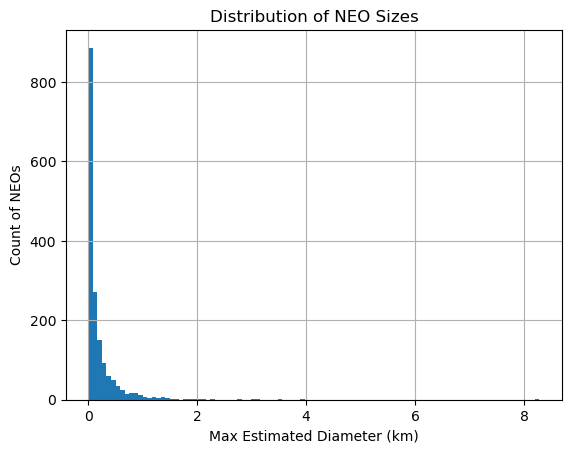

In [11]:
import matplotlib.pyplot as plt
# Histogram of estimated max diameters
full_neo_df["estimated_diameter_max_km"].hist(bins=100)
plt.xlabel("Max Estimated Diameter (km)")
plt.ylabel("Count of NEOs")
plt.title("Distribution of NEO Sizes")
plt.show()

## Part3 Integrate Launch Library 2 Data 
Queries the Launch Library 2 API for launch event data within a specified date range.

Filter by parameters of interest (e.g., launch provider, orbit type).

Convert the returned JSON into a structured pandas DataFrame.

Prepares the data to be integrated later with the NEO data (e.g., includes fields like launch date, provider name, and launch site name).

In [10]:
def fetch_all_launches(base_url, params):
    """
    Fetch all launch data from Launch Library 2 API within given parameters.
    This function handles pagination automatically.
    """
    all_launches = []
    url = base_url
    current_params = params.copy()
    
    while url:
        response = requests.get(url, params=current_params)
        if response.status_code == 200:
            data = response.json()
            launches = data.get("results", [])
            all_launches.extend(launches)
            
            next_url = data.get("next")
            if next_url:
                # 'next_url' is a full URL; set params to None for subsequent requests
                url = next_url
                current_params = None
            else:
                # No more pages
                break
        else:
            raise Exception(f"Failed to retrieve data. Status code: {response.status_code}, Response: {response.text}")
    
    return all_launches

In [11]:
def parse_launch_data(launches):
    """
    Parse the raw launch data (list of launches) into a pandas DataFrame.
    Extract relevant fields such as launch_id, name, status, window_start, window_end,
    provider, launch_site_name, launch_site_location, and orbit.
    """
    records = []
    for launch in launches:
        launch_id = launch.get("id")
        name = launch.get("name")
        status = launch.get("status", {}).get("name")
        window_start = launch.get("window_start")
        window_end = launch.get("window_end")
        provider = launch.get("launch_service_provider", {}).get("name")

        pad = launch.get("pad", {})
        launch_site_name = pad.get("name")
        launch_site_location = pad.get("location", {}).get("name")

        # Orbit info might be in mission key
        orbit = None
        mission = launch.get("mission", {})
        if isinstance(mission, dict):
            orbit = mission.get("orbit")

        records.append({
            "launch_id": launch_id,
            "name": name,
            "status": status,
            "window_start": window_start,
            "window_end": window_end,
            "provider": provider,
            "launch_site_name": launch_site_name,
            "launch_site_location": launch_site_location,
            "orbit": orbit
        })
    
    df = pd.DataFrame(records)
    return df

In [12]:
# Fetching launches from January 1 to March 31, 2024
base_url = "https://ll.thespacedevs.com/2.2.0/launch/"
params = {
    "window_start__gte": "2024-01-01",
    "window_end__lte": "2024-03-31",
    "limit": 1000
}

all_launches = fetch_all_launches(base_url, params)
full_launch_df = parse_launch_data(all_launches)

print("Combined Launch DataFrame:")
print(full_launch_df.head())
print("Number of launch records:", len(full_launch_df))


Combined Launch DataFrame:
                              launch_id  \
0  2a29a629-f28c-4fc4-8e5f-48e959e0a5b1   
1  161dbc75-e973-44f7-a346-6254aec99900   
2  1d374bef-0e4e-4b3f-b45b-25c14aaa2b0e   
3  7ec40d08-8efd-470a-907e-bb9d34fac5af   
4  60634a63-633d-42b3-b87e-710e7e0d4282   

                                     name             status  \
0                        PSLV-DL | XPoSat  Launch Successful   
1   Falcon 9 Block 5 | Starlink Group 7-9  Launch Successful   
2              Falcon 9 Block 5 | Ovzon-3  Launch Successful   
3            Kuaizhou-1A | Tianmu-1 15-18  Launch Successful   
4  Falcon 9 Block 5 | Starlink Group 6-35  Launch Successful   

           window_start            window_end  \
0  2024-01-01T03:40:00Z  2024-01-01T03:40:00Z   
1  2024-01-03T02:13:00Z  2024-01-03T06:02:10Z   
2  2024-01-03T23:04:00Z  2024-01-03T23:14:00Z   
3  2024-01-05T11:09:00Z  2024-01-05T11:32:00Z   
4  2024-01-07T21:00:40Z  2024-01-08T00:35:10Z   

                             provi

In [13]:
#clean data nice!
print(full_launch_df.info())
print(full_launch_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   launch_id             61 non-null     object
 1   name                  61 non-null     object
 2   status                61 non-null     object
 3   window_start          61 non-null     object
 4   window_end            61 non-null     object
 5   provider              61 non-null     object
 6   launch_site_name      61 non-null     object
 7   launch_site_location  61 non-null     object
 8   orbit                 61 non-null     object
dtypes: object(9)
memory usage: 4.4+ KB
None
launch_id               0
name                    0
status                  0
window_start            0
window_end              0
provider                0
launch_site_name        0
launch_site_location    0
orbit                   0
dtype: int64


In [15]:
# Save to CSV
full_launch_df.to_csv("full_launch_df.csv", index=False)
print("Data saved to full_launch_df.csv")

Data saved to full_launch_df.csv


## Part4 Wikipedia’s "List of rocket launch sites
Retrieve the HTML from Wikipedia’s "List of rocket launch sites" page.

Use BeautifulSoup to parse the page.

Identify and extract data from a relevant table (e.g., a table listing launch sites).

Convert the extracted data into a pandas DataFrame for further use.

In [16]:
from bs4 import BeautifulSoup
import pandas as pd
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_rocket_launch_sites"
# Expected columns in the tables of interest
expected_columns = [
    "Country",
    "Location",
    "Coordinates",
    "Operational date",
    "Number of rocket launches",
    "Heaviest rocket launched",
    "Highest achieved altitude",
    "Notes"
]

# Fetch the page content
response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"Failed to retrieve page. Status code: {response.status_code}")

# Parse the page with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Find all tables with class 'wikitable'
all_tables = soup.find_all("table", class_="wikitable")

df_list = []
for table in all_tables:
    # Extract header cells from the first row of the table
    header_row = table.find("tr")
    if not header_row:
        continue
    headers = [th.get_text(strip=True) for th in header_row.find_all("th")]
    
    # Check if this table has at least a 'Country' and 'Coordinates' column
    if "Country" in headers and "Coordinates" in headers:
        # Find all rows except the header
        rows = table.find_all("tr")[1:]
        
        table_data = []
        for tr in rows:
            tds = tr.find_all(["td", "th"])
            row_data = [td.get_text(strip=True) for td in tds]           
            # Only consider rows that have at least the number of expected columns
            # Some rows might have fewer columns due to notes or formatting
            if len(row_data) >= len(expected_columns):
                # Slice the row to match the expected columns length if there are extra columns
                row_data = row_data[:len(expected_columns)]
                table_data.append(row_data)
        
        if table_data:
            region_df = pd.DataFrame(table_data, columns=expected_columns)
            df_list.append(region_df)

if not df_list:
    raise Exception("No suitable launch site tables found.")

# Combine all DataFrames from different tables
launch_sites_df = pd.concat(df_list, ignore_index=True)

print("Launch Sites DataFrame:")
print(launch_sites_df.head())

Launch Sites DataFrame:
          Country                                           Location  \
0  French Algeria  Centre interarmées d'essais d'engins spéciaux ...   
1         Algeria                                            Reggane   
2           Zaire     Shaba North, Kapani Tonneo OTRAG Launch Center   
3           Egypt  Jabal Hamzah ballistic missile test and launch...   
4           Kenya           Broglio Space Centre (San Marco),Malindi   

                                         Coordinates Operational date  \
0  31°05′58″N2°50′09″W﻿ / ﻿31.09951°N 2.83581°W﻿ ...        1947–1967   
1  26°43′08″N0°16′37″E﻿ / ﻿26.71895°N 0.27691°E﻿ ...        1961–1965   
2  7°55′33″S28°31′40″E﻿ / ﻿7.92587°S 28.52766°E﻿ ...        1975–1979   
3  30°07′32.7″N30°36′18.5″E﻿ / ﻿30.125750°N 30.60...        1962–1973   
4  2°56′27″S40°12′48″E﻿ / ﻿2.94080°S 40.21340°E﻿ ...        1964–1988   

  Number of rocket launches Heaviest rocket launched  \
0                       230                18,00

#### we found there is a mismatch later, so add it here, no india value match later

In [17]:
#we found there is a mismatch later, so add it here
new_site = {
    "Country": "India",
    "Location": "Satish Dhawan Space Centre, Sriharikota, Andhra Pradesh, India",
    "Coordinates": "13°43′12″N 80°13′48″E",  # Example coordinates, please verify accuracy
    "Operational date": "1971–",
    "Number of rocket launches": "200+",
    "Heaviest rocket launched": "GSLV Mk III (~6400 kg to GTO)",
    "Highest achieved altitude": "Orbital",
    "Notes": "India's primary orbital launch center."
}

# Convert to a DataFrame and concatenate
new_site_df = pd.DataFrame([new_site])
new_site_df["Location_clean"] = new_site_df["Location"].str.strip().str.lower()

# Append this new site to your existing launch_sites_df
launch_sites_df = pd.concat([launch_sites_df, new_site_df], ignore_index=True)
# Now launch_sites_df includes the Indian site
correct_indian_site = "satish dhawan space centre, sriharikota, andhra pradesh, india"


In [18]:
#clean
print(launch_sites_df.info())
print(launch_sites_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Country                    88 non-null     object
 1   Location                   88 non-null     object
 2   Coordinates                88 non-null     object
 3   Operational date           88 non-null     object
 4   Number of rocket launches  88 non-null     object
 5   Heaviest rocket launched   88 non-null     object
 6   Highest achieved altitude  88 non-null     object
 7   Notes                      88 non-null     object
 8   Location_clean             1 non-null      object
dtypes: object(9)
memory usage: 6.3+ KB
None
Country                       0
Location                      0
Coordinates                   0
Operational date              0
Number of rocket launches     0
Heaviest rocket launched      0
Highest achieved altitude     0
Notes                   

In [19]:
from rapidfuzz import process, fuzz
# Inspect Columns
print("Launch DataFrame columns:", full_launch_df.columns)
print("Launch Sites DataFrame columns:", launch_sites_df.columns)
# launch_df has: 'launch_site_name', 'launch_site_location'
# launch_sites_df has: 'Country', 'Location', 'Coordinates', ..


Launch DataFrame columns: Index(['launch_id', 'name', 'status', 'window_start', 'window_end', 'provider',
       'launch_site_name', 'launch_site_location', 'orbit'],
      dtype='object')
Launch Sites DataFrame columns: Index(['Country', 'Location', 'Coordinates', 'Operational date',
       'Number of rocket launches', 'Heaviest rocket launched',
       'Highest achieved altitude', 'Notes', 'Location_clean'],
      dtype='object')


In [20]:
# Attempt a Direct Merge on a Key Column, but fail!!!
# First, let's standardize the strings by stripping whitespace and converting to lower case
full_launch_df["launch_site_location_clean"] = full_launch_df["launch_site_location"].str.strip().str.lower()
launch_sites_df["Location_clean"] = launch_sites_df["Location"].str.strip().str.lower()

# Try a direct merge
merged_df = full_launch_df.merge(launch_sites_df, left_on="launch_site_location_clean", right_on="Location_clean", how="left")

print("Merged DataFrame (direct attempt):")
print(merged_df.head())

# Check how many rows were actually matched
matched_count = merged_df["Location"].notna().sum()
print(f"Number of matched launch sites (direct match): {matched_count} out of {len(merged_df)}")


Merged DataFrame (direct attempt):
                              launch_id  \
0  2a29a629-f28c-4fc4-8e5f-48e959e0a5b1   
1  161dbc75-e973-44f7-a346-6254aec99900   
2  1d374bef-0e4e-4b3f-b45b-25c14aaa2b0e   
3  7ec40d08-8efd-470a-907e-bb9d34fac5af   
4  60634a63-633d-42b3-b87e-710e7e0d4282   

                                     name             status  \
0                        PSLV-DL | XPoSat  Launch Successful   
1   Falcon 9 Block 5 | Starlink Group 7-9  Launch Successful   
2              Falcon 9 Block 5 | Ovzon-3  Launch Successful   
3            Kuaizhou-1A | Tianmu-1 15-18  Launch Successful   
4  Falcon 9 Block 5 | Starlink Group 6-35  Launch Successful   

           window_start            window_end  \
0  2024-01-01T03:40:00Z  2024-01-01T03:40:00Z   
1  2024-01-03T02:13:00Z  2024-01-03T06:02:10Z   
2  2024-01-03T23:04:00Z  2024-01-03T23:14:00Z   
3  2024-01-05T11:09:00Z  2024-01-05T11:32:00Z   
4  2024-01-07T21:00:40Z  2024-01-08T00:35:10Z   

                          

### Because direct match fail due to column and key word not match

### So, we need fuzz match and add some assist column

In [21]:
# Extract list of known cleaned locations
site_locations_list = launch_sites_df["Location_clean"].unique().tolist()

def fuzzy_match(location, choices, scorer=fuzz.WRatio, cutoff=80):
    """Returns the best match above a given cutoff score using fuzzy matching."""
    best_match = process.extractOne(location, choices, scorer=scorer)
    if best_match and best_match[1] >= cutoff:
        return best_match[0]
    return None

# Identify rows that did not match directly
unmatched = merged_df[merged_df["Location"].isna()].copy()

# Apply special handling for the Indian site before fuzzy matching
for i, row in unmatched.iterrows():
    loc = row["launch_site_location_clean"]
    if "satish dhawan" in loc and "india" in loc:
        # Assign the known correct site directly without fuzzy logic
        unmatched.at[i, "fuzzy_match"] = correct_indian_site
    else:
        # Perform fuzzy matching for other locations
        unmatched.at[i, "fuzzy_match"] = fuzzy_match(loc, site_locations_list)

# Drop columns from unmatched that will be re-merged
unmatched = unmatched.drop(columns=["Location", "Country", "Coordinates", "Operational date",
                                    "Number of rocket launches", "Heaviest rocket launched", 
                                    "Highest achieved altitude", "Notes", "Location_clean"], errors='ignore')

# Merge the unmatched back with launch_sites_df using the fuzzy matched (or manually assigned) value
unmatched = unmatched.merge(launch_sites_df, left_on="fuzzy_match", right_on="Location_clean", how="left")

# Combine the now matched and previously matched rows
final_merged_df = pd.concat([merged_df[merged_df["Location"].notna()], unmatched], ignore_index=True)

print("Final Merged DataFrame with fuzzy matches and special handling for the Indian site:")
print(final_merged_df.head())

Final Merged DataFrame with fuzzy matches and special handling for the Indian site:
                              launch_id  \
0  2a29a629-f28c-4fc4-8e5f-48e959e0a5b1   
1  161dbc75-e973-44f7-a346-6254aec99900   
2  1d374bef-0e4e-4b3f-b45b-25c14aaa2b0e   
3  7ec40d08-8efd-470a-907e-bb9d34fac5af   
4  60634a63-633d-42b3-b87e-710e7e0d4282   

                                     name             status  \
0                        PSLV-DL | XPoSat  Launch Successful   
1   Falcon 9 Block 5 | Starlink Group 7-9  Launch Successful   
2              Falcon 9 Block 5 | Ovzon-3  Launch Successful   
3            Kuaizhou-1A | Tianmu-1 15-18  Launch Successful   
4  Falcon 9 Block 5 | Starlink Group 6-35  Launch Successful   

           window_start            window_end  \
0  2024-01-01T03:40:00Z  2024-01-01T03:40:00Z   
1  2024-01-03T02:13:00Z  2024-01-03T06:02:10Z   
2  2024-01-03T23:04:00Z  2024-01-03T23:14:00Z   
3  2024-01-05T11:09:00Z  2024-01-05T11:32:00Z   
4  2024-01-07T21:00:40Z  20

In [22]:
#there are something wrong with india one, i check, and find it not in the launch_sites_df. solve above
#print(launch_sites_df["Location_clean"].tolist())

Remove temporary columns like fuzzy_match and any other helper columns that you no longer need.

Keep only the columns that are useful for my analysis (e.g., launch_id, name, provider, Country, Location, Coordinates, Operational date).

## PART 5 FINAl MERGE

In [23]:
#Clean up final_merged_df by removing unnecessary columns
columns_to_remove = ["fuzzy_match", "Location_clean", "launch_site_location_clean"]
for col in columns_to_remove:
    if col in final_merged_df.columns:
        final_merged_df = final_merged_df.drop(columns=[col])
print("Cleaned Final Merged DataFrame:")
print(final_merged_df.head())

Cleaned Final Merged DataFrame:
                              launch_id  \
0  2a29a629-f28c-4fc4-8e5f-48e959e0a5b1   
1  161dbc75-e973-44f7-a346-6254aec99900   
2  1d374bef-0e4e-4b3f-b45b-25c14aaa2b0e   
3  7ec40d08-8efd-470a-907e-bb9d34fac5af   
4  60634a63-633d-42b3-b87e-710e7e0d4282   

                                     name             status  \
0                        PSLV-DL | XPoSat  Launch Successful   
1   Falcon 9 Block 5 | Starlink Group 7-9  Launch Successful   
2              Falcon 9 Block 5 | Ovzon-3  Launch Successful   
3            Kuaizhou-1A | Tianmu-1 15-18  Launch Successful   
4  Falcon 9 Block 5 | Starlink Group 6-35  Launch Successful   

           window_start            window_end  \
0  2024-01-01T03:40:00Z  2024-01-01T03:40:00Z   
1  2024-01-03T02:13:00Z  2024-01-03T06:02:10Z   
2  2024-01-03T23:04:00Z  2024-01-03T23:14:00Z   
3  2024-01-05T11:09:00Z  2024-01-05T11:32:00Z   
4  2024-01-07T21:00:40Z  2024-01-08T00:35:10Z   

                             

In [24]:
# Save to CSV
final_merged_df.to_csv("final_merged_df.csv", index=False)
print("final_merged_df saved to final_merged_df.csv")

final_merged_df saved to final_merged_df.csv


Convert Date Columns to Datetime:
Ensure that your date columns ( window_start for launches and close_approach_date for NEOs) are converted to datetime objects

In [25]:
final_merged_df["window_start"] = pd.to_datetime(final_merged_df["window_start"]).dt.tz_localize(None)
full_neo_df["close_approach_date"] = pd.to_datetime(full_neo_df["close_approach_date"]).dt.tz_localize(None)

Aggregate Data by Month

In [26]:
# Create a year-month column for both DataFrames
final_merged_df["year_month"] = final_merged_df["window_start"].dt.to_period("M")
full_neo_df["year_month"] = full_neo_df["close_approach_date"].dt.to_period("M")

# Aggregate launches by month
monthly_launches = final_merged_df.groupby("year_month").size().reset_index(name="launch_count")

# Aggregate NEOs by month
monthly_neos = full_neo_df.groupby("year_month").size().reset_index(name="neo_count")

In [27]:
#merge aggrgate data
monthly_combined = pd.merge(monthly_launches, monthly_neos, on="year_month", how="outer")
monthly_combined["year_month"] = monthly_combined["year_month"].dt.to_timestamp()

# Fill missing values if any
monthly_combined["launch_count"] = monthly_combined["launch_count"].fillna(0)
monthly_combined["neo_count"] = monthly_combined["neo_count"].fillna(0)

# Anlysis

In [28]:
correlation = monthly_combined["launch_count"].corr(monthly_combined["neo_count"])
print("Correlation between monthly launches and NEO counts:", correlation)


Correlation between monthly launches and NEO counts: 0.917662935482247


A correlation of approximately 0.9177 indicates a strong positive linear relationship between monthly launches and monthly NEO counts. 
During the months where the number of rocket launches was higher, the number of observed NEOs also tended to be higher.

In [29]:
print(monthly_combined)

  year_month  launch_count  neo_count
0 2024-01-01            23        573
1 2024-02-01            19        548
2 2024-03-01            19        558


For analysis of NEO Count by Orbiting Body, Launch Count by Provider,Analyze Hazardous NEOs, and Launch-NEO Match Analysis 
please move to example.ipynb